## Описание проекта
**Определение перспективного тарифа для телеком компании**

Компания «Мегалайн» — федеральный оператор сотовой связи, который предлагает клиентам два тарифных плана: «Смарт» и «Ультра». 
Коммерческий департамент хочет скорректировать рекламный бюджет, поэтому необходимо понять какой тариф приносит больше денег.

В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
* минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
* сообщение: 3 рубля;
* 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
* минута разговора: 1 рубль; 
* сообщение: 1 рубль; 
* 1 Гб интернет-трафика: 150 рублей.

**Описание данных**


**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение общей информации

**Импортируем библиотеки**

In [1]:
import pandas as pd
import seaborn as sns
import math
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from functools import reduce
idx = pd.IndexSlice
from scipy import stats as st

**Получим общую информацию о наших данных**

In [2]:
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
calls = pd.read_csv('/datasets/calls.csv')

for data in [users, tariffs, messages, internet, calls]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non

**Вывод**

Следующие колонки (признаки) необходимо привести к типу DateTime:
* дата прекращения пользования тарифом (churn_date);
* дата подключения тарифа (reg_date);
* дата сообщения (message_date);
* дата интернет-сессии (session_date);
* дата звонка (call_date).

В большинстве признаков пропусков, которые нужно заполнить нет.

**Проверим данные на наличие дубликатов**

In [3]:
for data in [calls, internet, messages, users, tariffs]: 
    print('Количество дубликатов: {}'.format(data.duplicated().sum()))

Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0


В наших данных дубликатов нет

**Вывод**
1. Следующие колонки (признаки) необходимо привести к типу DateTime:
* дата прекращения пользования тарифом (churn_date);
* дата подключения тарифа (reg_date);
* дата сообщения (message_date);
* дата интернет-сессии (session_date);
* дата звонка (call_date).
2. К типу данных int64:
* длительность звонка в минутах (duration);
* объем потраченного за сессию интернет-трафика (mb_used).
3. В наших данных дубликатов нет.
4. В большинстве признаков пропусков, которые нужно заполнить нет. Посмотрим на значения, когда объединим таблицы.

## Предобработка данных

**Округлим минуты в большую сторону у тарифов, а нулевые значения заменим на 1**

In [4]:
calls['duration'] = np.ceil(calls['duration'])
calls.loc[calls['duration'] == 0, 'duration'] = 1
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

**Поменяем тип данных**

In [5]:
def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')

# Даты
to_datetime(users, ['reg_date', 'churn_date'])
to_datetime(calls, ['call_date'])
to_datetime(messages, ['message_date'])
to_datetime(internet, ['session_date'])

# Минуты
calls['duration'] = calls['duration'].astype('int64')

**Посчитаем для каждого пользователя:**
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;

In [6]:
# Таблица по звонкам
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls_grouped = calls.pivot_table(values='duration', 
                                index=['user_id','month'], 
                                aggfunc=['count', 'sum']).rename(columns={'duration': 'total_calls'})

# Таблица по сообщениям
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_grouped = messages.pivot_table(values='id', 
                                        index=['user_id', 'month'],
                                        aggfunc='count')

# Таблица по интернет-трафику
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
internet_grouped = internet.pivot_table(values='mb_used',
                                        index=['user_id', 'month'], 
                                        aggfunc='sum') 
internet_grouped['gb_used'] = internet_grouped['mb_used'].apply(lambda x: math.ceil(x / 1024) * 1024)

# Создадим временный DataFrame c таблицей calls_grouped
tempdata = pd.DataFrame(calls_grouped.to_records())

# Создадим grouped_data датафрейм для рассчетов и перенесем в него столбцы, столбцы переименуем
grouped_data = pd.DataFrame()
grouped_data['user_id'] = tempdata['user_id']
grouped_data['month']   = tempdata['month']
grouped_data['calls']   = tempdata.iloc[:, 2]
grouped_data['duration'] = tempdata.iloc[:, 3]

# Создадим временный DataFrame с таблицей messages_grouped, переименуем столбец id  в messages, соединим его с grouped_data
tempdata = pd.DataFrame(messages_grouped.to_records()).rename(columns={'id': 'messages'})
grouped_data = grouped_data.merge(tempdata, on=['user_id', 'month'], how='outer')

# Создадим временный датафрейм с таблицей internet_grouped и соединим его с grouped_data
tempdata = pd.DataFrame(internet_grouped.to_records())
grouped_data = grouped_data.merge(tempdata, on=['user_id', 'month'], how='outer')

# Создадим датафрейм tariff_grouped и перенесем в него столбцы из таблицы users, чтобы соединить с grouped_data
tariff_grouped = pd.DataFrame()
tariff_grouped[['user_id','tariff','city']] = users[['user_id','tariff','city']]
grouped_data = grouped_data.merge(tariff_grouped, on='user_id', how='outer')
grouped_data.sample(5)

,user_id,month,calls,duration,messages,mb_used,gb_used,tariff,city
2546,1401,11.0,41.0,354.0,56.0,11241.61,11264.0,smart,Москва
2819,1441,11.0,11.0,82.0,28.0,25066.30,25600.0,smart,Самара
3044,1477,8.0,101.0,813.0,63.0,19968.72,20480.0,smart,Набережные Челны
1709,1274,9.0,54.0,448.0,66.0,22402.55,22528.0,smart,Волгоград
198,1031,11.0,86.0,682.0,25.0,11296.07,12288.0,smart,Москва


**Пропущенные значения заменим на нули**

In [7]:
grouped_data = grouped_data.fillna(0)
grouped_data.isnull().sum()

user_id     0
month       0
calls       0
duration    0
messages    0
mb_used     0
gb_used     0
tariff      0
city        0
dtype: int64

**Запишем функцию подсчета помесячной выручки с каждого пользователя**

In [8]:
#Просто пропишем значения для расчетов
# Для тарифа «Смарт»
smart_megabytes_included = 15360 # включено 15360 мегабайт интернет-трафика
smart_messages_included = 50 # включено 50 сообщений
smart_minutes_included = 500 # включено 500 минут разговора
smart_monthly_price = 550 # ежемесячная плата 550 рублей
smart_price_for_megabyte = 0.1953 # цена за мегабайт сверх пакета
smart_price_for_message = 3 # цена за сообщение сверх пакета
smart_price_for_minute = 3 # цена за минуту разговора сверх пакета

# Для тарифа «Ультра»
ultra_megabytes_included = 30720 # включено 30720 мегабайт интернет-трафика
ultra_messages_included = 1000 # включено 1000 сообщений
ultra_minutes_included = 3000 # включено 3000 минут разговора
ultra_monthly_price = 1950 # ежемесячная плата 1950 рублей
ultra_price_for_megabyte = 0.1464 # цена за мегабайт сверх пакета
ultra_price_for_message = 1 # цена за сообщение сверх пакета
ultra_price_for_minute = 1 # цена за минуту разговора сверх пакета

# Функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    # Объявим переменные из столбцов нашей таблицы
    mb_used = row['gb_used']
    tariff = row['tariff']
    minutes = row['duration']
    messages = row['messages']
    total_megabytes = 0
    total_messages = 0 
    total_minutes = 0
    
    # Если тариф «Смарт», то будут использоваться эти расчеты:
    if tariff == 'smart':
        if mb_used > smart_megabytes_included:
            total_megabytes = (mb_used - smart_megabytes_included) * smart_price_for_megabyte
        if minutes > smart_minutes_included:
            total_minutes = (minutes - smart_minutes_included) * smart_price_for_minute
        if messages > smart_messages_included:
            total_messages = (messages - smart_messages_included) * smart_price_for_message
        
        return total_megabytes + total_minutes + total_messages + smart_monthly_price
    
    # Если тариф «Ультра», то эти:
    if tariff == 'ultra':
        if mb_used > ultra_megabytes_included:
            total_megabytes = (mb_used - ultra_megabytes_included) * ultra_price_for_megabyte
        if minutes > ultra_minutes_included:
            total_minutes = (minutes - ultra_minutes_included) * ultra_price_for_minute
        if messages > ultra_messages_included:
            total_messages = (messages - ultra_messages_included) * ultra_price_for_message
        return total_megabytes + total_minutes + total_messages + ultra_monthly_price

# Вызовем функцию det_revenue с помощью метода apply и передадим все столбцы через axis = 1
grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.sample(5)

,user_id,month,calls,duration,messages,mb_used,gb_used,tariff,city,revenue
319,1051,9.0,55.0,322.0,6.0,14294.08,14336.0,smart,Москва,550.0000
1954,1312,8.0,72.0,547.0,38.0,19907.15,20480.0,smart,Санкт-Петербург,1690.9360
2746,1430,11.0,46.0,319.0,39.0,19378.91,19456.0,ultra,Тверь,1950.0000
3006,1472,2.0,56.0,469.0,80.0,19156.83,19456.0,smart,Ярославль,1439.9488
40,1005,11.0,75.0,562.0,51.0,12668.95,13312.0,smart,Набережные Челны,739.0000


**Вывод**

Посчитали для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя.

## Анализ данных

**Передадим переменным smart_tariff и ultra_tariff данные из таблицы**

In [9]:
smart_tariff = grouped_data[grouped_data['tariff']=='smart']
ultra_tariff = grouped_data[grouped_data['tariff']=='ultra']

**Посчитаем сколько минут разговора, сообщений и какой объем мегабайт требуется пользователям тарифа «Смарт» в месяц**

In [10]:
smart_pivot = smart_tariff.pivot_table(index='month', values=['duration','messages','mb_used','revenue'], aggfunc='sum')
smart_stat = pd.DataFrame(smart_pivot.to_records())
smart_stat.drop(0)

,month,duration,mb_used,messages,revenue
1,1.0,7128.0,289607.40,620.0,24593.6416
2,2.0,17766.0,672974.15,1397.0,48432.1552
3,3.0,30841.0,1163586.25,2453.0,90747.5552
4,4.0,42224.0,1508503.23,3443.0,109183.6960
5,5.0,56175.0,2229595.99,4762.0,170889.0336
6,6.0,66699.0,2591581.27,5478.0,199954.2272
7,7.0,84277.0,3165958.22,6784.0,249733.8576
8,8.0,101800.0,3905408.22,7905.0,314929.4896
9,9.0,114421.0,4241033.49,8746.0,329760.7712
10,10.0,128859.0,4929031.13,9927.0,407104.4688


**Посчитаем среднее количество, дисперсию и стандартное отклонение для тарифа «Смарт»**

In [11]:
smart_tariff[['duration','messages','mb_used','revenue']].agg(['mean','median','var','std']).style.format('{:.0f}')

,duration,messages,mb_used,revenue
mean,429,33,16209,1308
median,434,28,16514,1067
var,38040,797,34590995,685808
std,195,28,5881,828


**Посчитаем сколько минут разговора, сообщений и какой объем мегабайт требуется пользователям тарифа «Ультра» в месяц**

In [12]:
ultra_pivot = ultra_tariff.pivot_table(index='month', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='sum')
ultra_stat = pd.DataFrame(ultra_pivot.to_records())
ultra_stat.drop(0)

,month,duration,mb_used,messages,revenue
1,1.0,3968.0,118276.13,304.0,17550.0000
2,2.0,7312.0,282655.50,527.0,47399.6544
3,3.0,18614.0,648872.36,1195.0,74548.6176
4,4.0,25854.0,925627.39,1736.0,110098.3584
5,5.0,35166.0,1297465.25,2536.0,137995.7664
6,6.0,41364.0,1589836.90,3505.0,171445.5936
7,7.0,50987.0,1865280.53,4536.0,192741.1872
8,8.0,56129.0,2094831.85,5183.0,222891.7920
9,9.0,63669.0,2208702.87,6013.0,232795.0752
10,10.0,70458.0,2465781.49,7187.0,254091.7920


**Посчитаем среднее количество, дисперсию и стандартное отклонение для тарифа «Ультра»**

In [13]:
ultra_tariff[['duration','messages','mb_used','revenue']].agg(['mean','median','var','std']).style.format('{:.0f}')

,duration,messages,mb_used,revenue
mean,540,49,19451,2070
median,532,38,19305,1950
var,106295,2285,102048129,141622
std,326,48,10102,376


**Напишем функцию для построения гистограмм**

In [14]:
def histogram_drawing(column, title):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,6))
    plt.title(title, fontsize=15)
    sns.distplot(smart_tariff[column], label='Тариф «Смарт»', kde=False)
    sns.distplot(ultra_tariff[column], label='Тариф «Ультра»', kde=False)
    plt.axvline(np.mean(smart_tariff[column]),color='red', linestyle='--', label='Smart среднее')
    plt.axvline(np.mean(ultra_tariff[column]),color='red', linestyle='-', label='Ultra среднее')
    plt.legend()

**Построим гистограммы распределения по интернет-трафику, длительности разговора и числу сообщений для тарифов «Смарт» и «Ультра»**

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


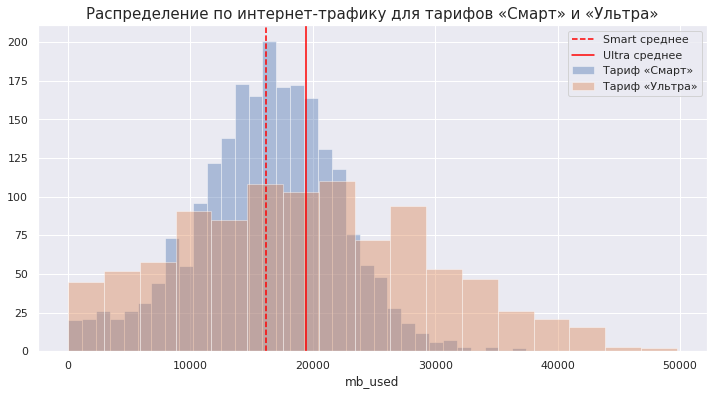

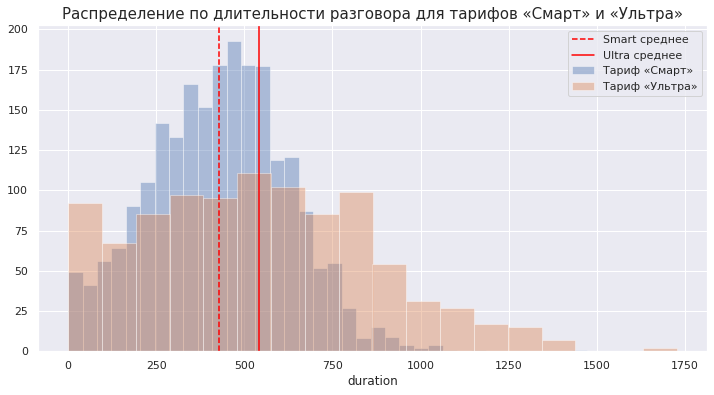

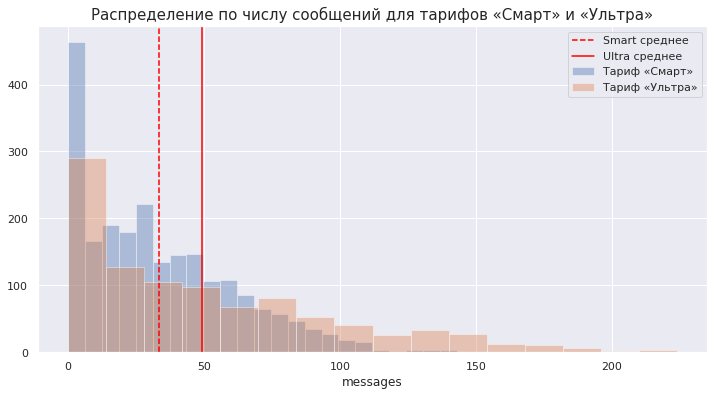

In [15]:
histogram_drawing('mb_used', 'Распределение по интернет-трафику для тарифов «Смарт» и «Ультра»')
histogram_drawing('duration','Распределение по длительности разговора для тарифов «Смарт» и «Ультра»')
histogram_drawing('messages','Распределение по числу сообщений для тарифов «Смарт» и «Ультра»')

**Вывод**

* Пользователи тарифа «Ультра» скачивают в среднем 19451 мегабайт, когда пользователи тарифа «Смарт» скачивают в среднем 16209 мегабайт;
* У пользователей тарифа «Ультра» в среднем длительность разговора 540 минут, когда длительность разговора пользователей тарифа «Смарт» в среднем равна 429 минут;
* Пользователи тарифа «Ультра» отправляют 49 сообщений, когда пользователи тарифа «Смарт» в среднем отправляют 33 сообщения.
* При этом длительность разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» также имеет большую дисперсию, медианы и среднее отклонение по сравнению с тарифом «Смарт».

## Проверка гипотез

**1. Первая гипотеза**

Для проверки гипотез принимаем нулевую гипотезу:
* H0  — средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.

Альтернативная гипотеза:
* H1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Критический уровень статистической значимости зададим равный 5%.

In [16]:
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = 0.05  # Критический уровень статистической значимости
             # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.758456601732254e-237
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу. Значения средней выручки тарифов «Ультра» и «Смарт» различаются.

**2. Вторая гипотеза**

Для проверки гипотез принимаем нулевую гипотезу:
* H0  — средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Альтернативная гипотеза:
* H1  — средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

Критический уровень статистической значимости зададим равный 5%.

In [17]:
moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = 0.05  # Критический уровень статистической значимости,
             # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(moscow, regions, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5453953599097974
Не получилось отвергнуть нулевую гипотезу


Мы не можем отвергнуть нулевую гипотезу, поэтому принимаем, что средняя выручка пользователей из Москвы не отличается от пользователей из других регионов.

**Вывод**

В результате проверки гипотез мы получили средующее:
* значения средней выручки тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы не отличается от пользователей из других регионов.

## Общий вывод

**По результатам анализа наших данных мы получили следующее:**

* В результате проверки гипотез мы убедились, что средняя выручка пользователей тарифов «Смарт» и «Ультра» различается.
* Убедились, что средняя выручка пользователей из Москвы не отличается от пользователей из других регионов.
* По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт», поэтому рекламный бюджет выгоднее всего перераспределить в пользу тарифа «Ультра». 